## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [9]:
LEARNING_RATE = 1e-3
EPOCHS = 10 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 256

In [10]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3,0.7]
redice_lr_patient = [3,7]

In [11]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(
    factor=reduce_factor,
    patience=reduce_patient,
    monitor="val_loss",
    verbose=1,
    min_lr=1e-12)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 4s 77us/step - loss: 1.3765 - acc: 0.5200 - val_loss: 1.5224 - val_acc: 0.4614
Epoch 8/10
50000/50000 [==============================] - 4s 79us/step - loss: 1.3422 - acc: 0.5313 - val_loss: 1.5142 - val_acc: 0.4654
Epoch 9/10
50000/50000 [==============================] - 4s 83us/step - loss: 1.3083 - acc: 0.5437 - val_loss: 1.4971 - val_acc: 0.4701
Epoch 10/10
50000/50000 [==============================] - 4s 76us/step - loss: 1.2783 - acc: 0.5557 - val_loss: 1.4833 - val_acc: 0.4768
Numbers of exp: 3, reduce_factor: 0.70, reduce_patient: 7
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_no

50000/50000 [==============================] - 5s 103us/step - loss: 1.4563 - acc: 0.4887 - val_loss: 1.7134 - val_acc: 0.3958
Epoch 3/10
50000/50000 [==============================] - 6s 111us/step - loss: 1.3597 - acc: 0.5228 - val_loss: 1.5286 - val_acc: 0.4615
Epoch 4/10
50000/50000 [==============================] - 5s 105us/step - loss: 1.2907 - acc: 0.5487 - val_loss: 1.5016 - val_acc: 0.4677
Epoch 5/10
50000/50000 [==============================] - 5s 102us/step - loss: 1.2296 - acc: 0.5707 - val_loss: 1.4997 - val_acc: 0.4693
Epoch 6/10
50000/50000 [==============================] - 5s 101us/step - loss: 1.1797 - acc: 0.5889 - val_loss: 1.4869 - val_acc: 0.4749
Epoch 7/10
50000/50000 [==============================] - 5s 100us/step - loss: 1.1345 - acc: 0.6083 - val_loss: 1.5903 - val_acc: 0.4493
Epoch 8/10
50000/50000 [==============================] - 6s 122us/step - loss: 1.0950 - acc: 0.6215 - val_loss: 1.4741 - val_acc: 0.4857
Epoch 9/10
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 7s 131us/step - loss: 1.6981 - acc: 0.4000 - val_loss: 2.2581 - val_acc: 0.2665
Epoch 2/10
50000/50000 [==============================] - 4s 81us/step - loss: 1.4763 - acc: 0.4757 - val_loss: 2.5932 - val_acc: 0.2607
Epoch 3/10
50000/50000 [==============================] - 4s 84us/step - loss: 1.3816 - acc: 0.5107 - val_loss: 2.0803 - val_acc: 0.2953
Epoch 4/10
50000/50000 [==============================] - 4s 83us/step - loss: 1.3126 - acc: 0.5354 - val_loss: 1.8447 - val_acc: 0.3786
Epoch 5/10
50000/50000 [==============================] - 4s 81us/step - loss: 1.2582 - acc: 0.5536 - val_loss: 1.8980 - val_acc: 0.3545
Epoch 6/10
50000/50000 [==============================] - 4s 81us/step - loss: 1.2194 - acc: 0.5686 - val_loss: 1.8374 - val_acc: 0.3940
Epoch 7/10
50000/50000 [==============================] - 4s 82us/step - loss: 1.1712 - acc: 0.5856 - val_loss: 1.8845 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 7s 146us/step - loss: 1.7012 - acc: 0.3982 - val_loss: 2.5136 - val_acc: 0.2055
Epoch 2/10
50000/50000 [==============================] - 4s 88us/step - loss: 1.4682 - acc: 0.4790 - val_loss: 2.2967 - val_acc: 0.2787
Epoch 3/10
50000/50000 [==============================] - 5s 103us/step - loss: 1.3754 - acc: 0.5128 - val_loss: 2.3295 - val_acc: 0.2806
Epoch 4/10
50000/50000 [==============================] - 5s 106us/step - loss: 1.3066 - acc: 0.5363 - val_loss: 1.9515 - val_acc: 0.3466
Epoch 5/10
50000/50000 [==============================] - 5s 107us/step - loss: 1.2628 - acc: 0.5524 - val_loss: 2.0249 - val_acc: 0.3711
Epoch 6/10
50000/50000 [==============================] - 5s 91us/step - loss: 1.2129 - acc: 0.5708 - val_loss: 1.7850 - val_acc: 0.3854
Epoch 7/10
50000/50000 [==============================] - 4s 89us/step - loss: 1.1653 - acc: 0.5874 - val_loss: 1.9087 - val

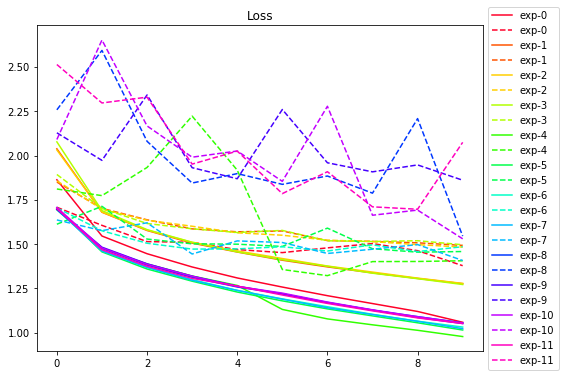

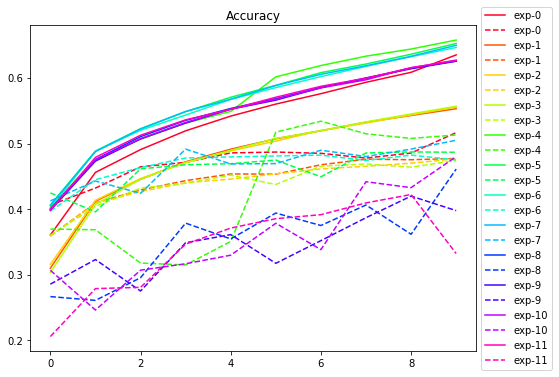

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()